# Design a DNN for image classification

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Run the Model on CUDA

In [2]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparing the data

1.   Loading data from torch libs
2.   Creating the train and test sets using
3.   Getting familiar with the data
4.   Creating batch datasets of train and test sets for training & testing of the model



In [3]:
# defining the train set
train = torchvision.datasets.CIFAR10(root='./dataset',download=True,train=True,transform=transforms.ToTensor())
train[0]

100%|██████████| 170498071/170498071 [00:05<00:00, 31268616.88it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [4]:
# defining the test set
test = torchvision.datasets.CIFAR10(root='./dataset',download=True,train=False,transform=transforms.ToTensor())
test

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# get the labels:
labels = []
for item in train:
  labels.append(item[1])

# labels = torch.tensor(labels)

In [6]:
list(set(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

9


<ipython-input-7-b11a90dea9bb>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.imshow(image.T, interpolation='bicubic') # it should be (m,n,3) so thats why we are transpose it


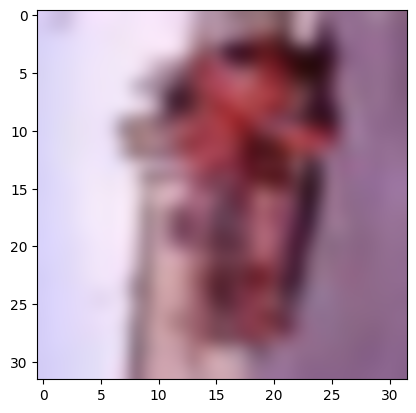

In [7]:
image, label = train[67]
print(label)
plt.imshow(image.T, interpolation='bicubic') # it should be (m,n,3) so thats why we are transpose it
plt.show()

In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size=100,shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=100,shuffle=True)

# Neural Network Creation

In [9]:
class DNN(nn.Module):

  def __init__(self,input_size,hidden_size1,hidden_size2,num_classes):
    super(DNN,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
    self.relu = nn.ReLU()
    self.out = nn.Linear(hidden_size2, num_classes, bias=True)


  def forward(self,x):
    output = x.view(x.size(0),-1)
    output = self.fc1(output)
    output = self.relu(output)
    output = self.fc2(output)
    output = self.relu(output)
    output = self.out(output)

    return output

initializing the network

In [10]:
input_size = 3*32*32
hidden_size1 = 120
hidden_size2 = 100
num_classes = 10

In [11]:
model = DNN(input_size,hidden_size1,hidden_size2,num_classes).to(device)   # for running on GPU
# model = DNN(input_size,hidden_size1,hidden_size2,num_classes)              # for running on CPU
loss_fcn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

# Training

In [12]:
import time
start_time = time.time()

loss_list = []
accuracy_list = []

num_epochs = 50
for epoch in range(num_epochs):
  epoch_loss = 0
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    predicted_label = model(images)
    loss = loss_fcn(predicted_label,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
  loss_list.append(epoch_loss)

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data,1)  # shows the index of the max value of the output data (highest class score)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      accuracy = correct/total
      accuracy_list.append(accuracy)

    print('epoch [{}/50]  accuracy epoch: {:.4f}'.format(epoch+1, accuracy),'loss: {:.4f}'.format(loss_list[-1]))

print('execution time: ', time.time()-start_time)


epoch [1/50]  accuracy epoch: 0.2618 loss: 1086.7038
epoch [2/50]  accuracy epoch: 0.3205 loss: 983.6248
epoch [3/50]  accuracy epoch: 0.3405 loss: 942.7127
epoch [4/50]  accuracy epoch: 0.3565 loss: 916.4258
epoch [5/50]  accuracy epoch: 0.3720 loss: 895.9027
epoch [6/50]  accuracy epoch: 0.3847 loss: 878.2158
epoch [7/50]  accuracy epoch: 0.3880 loss: 861.7873
epoch [8/50]  accuracy epoch: 0.4028 loss: 847.4314
epoch [9/50]  accuracy epoch: 0.4164 loss: 834.9685
epoch [10/50]  accuracy epoch: 0.4220 loss: 823.5004
epoch [11/50]  accuracy epoch: 0.4291 loss: 813.1133
epoch [12/50]  accuracy epoch: 0.4402 loss: 803.0754
epoch [13/50]  accuracy epoch: 0.4286 loss: 794.5140
epoch [14/50]  accuracy epoch: 0.4486 loss: 785.4426
epoch [15/50]  accuracy epoch: 0.4618 loss: 777.0116
epoch [16/50]  accuracy epoch: 0.4654 loss: 768.8178
epoch [17/50]  accuracy epoch: 0.4714 loss: 761.7621
epoch [18/50]  accuracy epoch: 0.4763 loss: 754.7839
epoch [19/50]  accuracy epoch: 0.4785 loss: 749.2689
e

Testing

In [14]:
with torch.no_grad():
  correct=0
  total=0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    test_out = model(images)
    _,test_pred = torch.max(test_out,1)
    total += labels.size(0)
    correct += (test_pred == labels).sum().item()
  print('Test accuracy: {:.4f}'.format(correct/total))

Test accuracy: 0.5184


**Confusion Matrix**

In [16]:
from sklearn.metrics import confusion_matrix

with torch.no_grad():
  correct=0
  total=0
  confusion_matrix = torch.zeros(10,10)
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    pred_out = model(images)
    _,predicted_label = torch.max(pred_out,1)
    total += labels.size(0)
    correct += (predicted_label == labels).sum().item()

    for i, j in zip(predicted_label,labels):
      confusion_matrix[i][j] += 1

print(confusion_matrix.numpy().astype(int))


[[524  24  76  18  40  10   3  18  65  30]
 [ 26 633  18  14   9   7  11  14  59 164]
 [ 31   9 240  31  59  29  20  16   6   4]
 [ 41  37 121 362  73 198  96  69  29  49]
 [ 27   5 109  34 355  40  64  51  12   6]
 [ 36  25 140 250  85 492  69  92  43  37]
 [ 27  21 165 158 213  90 688  40  13  30]
 [ 53  34  93  80 123  93  26 653  24  66]
 [181  85  23  21  29  21  13  12 700  77]
 [ 54 127  15  32  14  20  10  35  49 537]]


# Saving the model

In [17]:
save_state = {'model':model.state_dict(), 'optimizer':optimizer.state_dict()}
torch.save(save_state,'DNN.pth')

# Load the model

In [18]:
state = torch.load('DNN.pth')
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])

<ipython-input-18-723b618a8c8f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('DNN.pth')
